In [1]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

In [0]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


# define paths
#output_path = '/content/drive/My Drive/Fax/Master Theses/output-LSTM'
#model_path = output_path+'/mode.h5'

data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)



In [0]:
##################################
# Data Preprocessing
##################################
#no

In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

In [0]:

######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
label_array.shape

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]
142
(15631, 50, 25)


(15631, 1)

In [0]:
testni_rulovi = []
for id in test_df['id'].unique():
  testni_rulovi.append(test_df[test_df['id']==id]['RUL'].max())
testni_rulovi.sort()

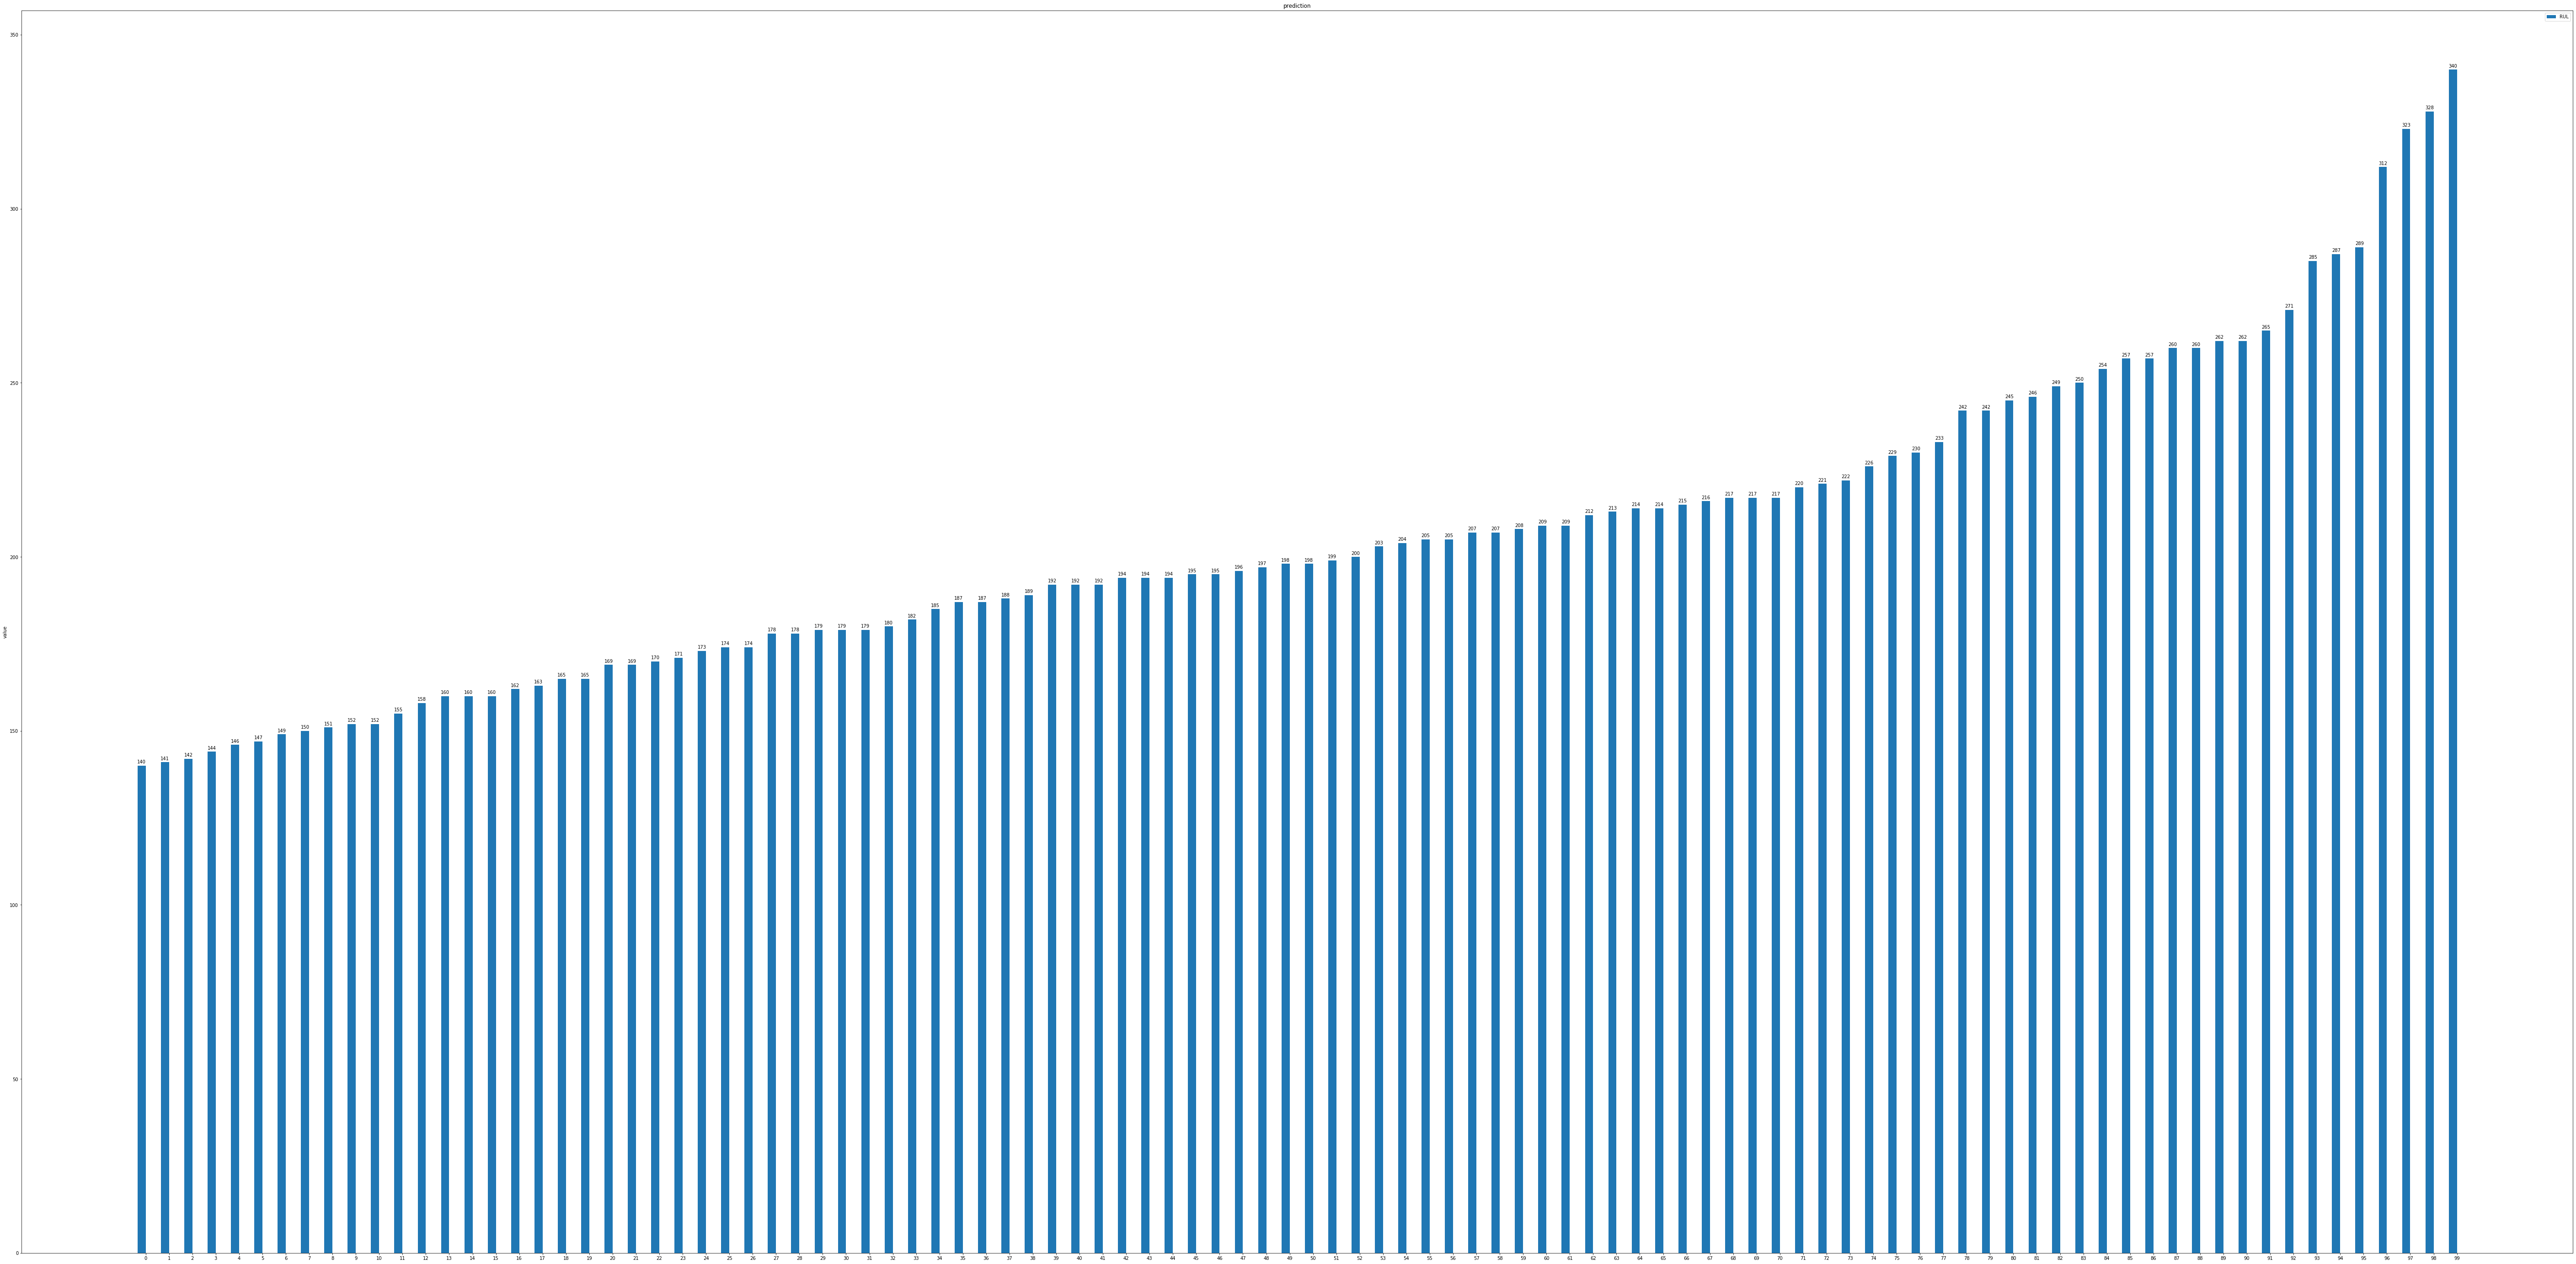

In [0]:
x = np.arange(len(testni_rulovi))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(100, 50))
rects1 = ax.bar(x - width/2,testni_rulovi, width, label='RUL')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('prediction')
ax.set_xticks(x)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.show()

In [0]:
train_rulovi = []
for id in train_df['id'].unique():
  train_rulovi.append(train_df[train_df['id']==id]['RUL'].max())
train_rulovi.sort()
print(train_rulovi)

[127, 134, 136, 136, 146, 146, 149, 152, 153, 153, 154, 155, 155, 157, 157, 157, 162, 162, 164, 165, 167, 169, 169, 171, 173, 177, 178, 179, 179, 180, 184, 184, 184, 187, 187, 187, 188, 190, 191, 191, 192, 193, 193, 194, 194, 194, 194, 195, 197, 198, 198, 198, 199, 199, 200, 201, 201, 201, 206, 206, 207, 208, 209, 212, 212, 212, 212, 212, 213, 213, 214, 215, 216, 221, 228, 229, 230, 230, 230, 233, 233, 239, 239, 255, 256, 257, 258, 266, 268, 274, 275, 277, 282, 282, 286, 292, 312, 335, 340, 361]


In [0]:
np.random.seed(10)
collectn_1 = np.random.normal(100, 10, 200)
collectn_2 = np.random.normal(80, 30, 200)
collectn_3 = np.random.normal(90, 20, 200)
collectn_4 = np.random.normal(70, 25, 200)

## combine these different collections into a list    
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]

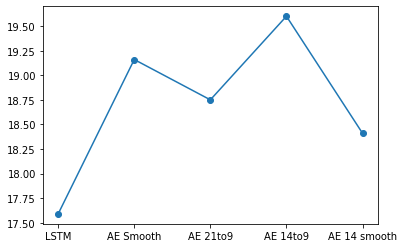

In [0]:
#autoencoder
plt.plot( ['LSTM', 'AE Smooth', 'AE 21to9', 'AE 14to9','AE 14 smooth'],[17.59, 19.16, 18.75,19.60,18.41 ], linestyle='-', marker='o')
#plt.axis([-1, 10, 15, 23])
plt.show()

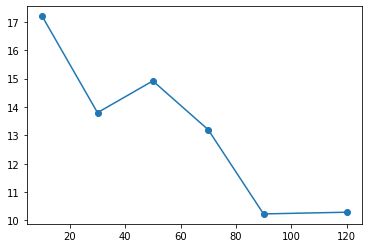

In [0]:
#window size
plt.plot( [10, 30, 50, 70 ,90, 120],[17.20, 13.80, 14.92, 13.20, 10.23, 10.29 ], linestyle='-', marker='o')
#plt.axis([0, 130, 9, 19])
plt.show()

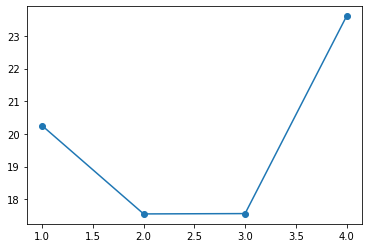

In [0]:
#number of layers
plt.plot( [1, 2, 3, 4 ],[20.25, 17.55, 17.56, 23.60 ], linestyle='-', marker='o')
#plt.axis([0, 130, 9, 19])
plt.show()

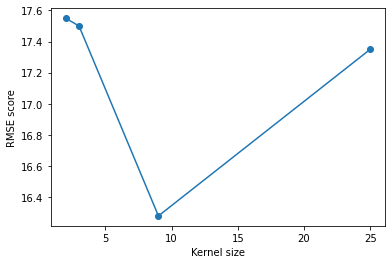

In [4]:
#kernel size
plt.plot( [ 2, 3, 9, 25 ],[17.55, 17.50, 16.28, 17.35 ], linestyle='-', marker='o')
plt.ylabel('RMSE score')
plt.xlabel('Kernel size')
#plt.plot( [ 2, 3, 9, 25 ],[2, 2.2 , 2.5, 4], linestyle='-', marker='o')
#plt.axis([0, 130, 9, 19])
plt.show()

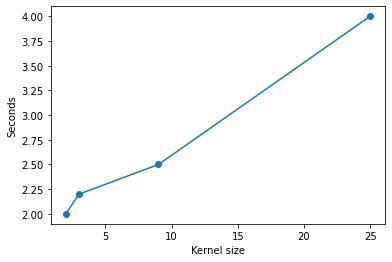

In [6]:
#kernel size
#plt.plot( [ 2, 3, 9, 25 ],[17.55, 17.50, 16.28, 17.35 ], linestyle='-', marker='o')
plt.ylabel('Seconds')
plt.xlabel('Kernel size')
plt.plot( [ 2, 3, 9, 25 ],[2, 2.2 , 2.5, 4], linestyle='-', marker='o')
#plt.axis([0, 130, 9, 19])
plt.show()

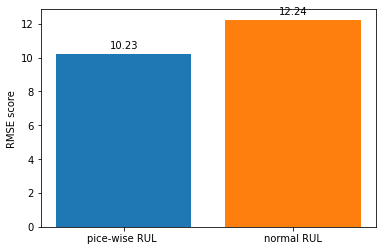

In [0]:

fig, ax = plt.subplots()
rects1 = ax.bar('pice-wise RUL ' ,10.23)
rects2 = ax.bar('normal RUL' ,12.24)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE score')
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

plt.show()